In [2]:
import math
import json

import math
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import base64
import io
from PIL import Image
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer
import cv2
from tqdm.auto import tqdm
import torch.utils.checkpoint as checkpoint

torch.backends.cuda.enable_flash_sdp(True)
# set white background in matplotlib
plt.rcParams['figure.facecolor'] = 'white'

In [10]:
# data_path = '/projets/melodi/gsantoss/pages.json'
data_path = '/projets/melodi/gsantoss/pdf/dataset.json'

with open(data_path) as f:
    data = json.load(f)

def slice_image(img, size=16, stride=16):
    p_imag = img.unfold(0, size, stride).unfold(1, size, stride)
    return torch.flatten(p_imag, 0, end_dim=1)

tokenizer = AutoTokenizer.from_pretrained('google/byt5-small')

imgs = []
texts = []

for doc_image, doc_text in tqdm(data):
    # doc_image, doc_text = d['image'], d['text']
    try:
        img = base64.b64decode(doc_image[22:])
        img = torch.from_numpy(np.array(Image.open(io.BytesIO(img)))) 

        # convert image to grayscale using cv2
        img = cv2.cvtColor(img.numpy(), cv2.COLOR_BGR2GRAY)
        img = torch.from_numpy(img) / 255.0
        
        # resize image to 517x400        
        img = nn.functional.interpolate(img.unsqueeze(0).unsqueeze(0), size=(517, 400), mode='bilinear', align_corners=False).squeeze(0).squeeze(0)
        imgs.append(torch.flatten(slice_image(img, size=16, stride=16), start_dim=1).unsqueeze(0))

        texts.append('<s>' + doc_text)
    except:
        break
        pass
    
tokens = tokenizer(texts, return_tensors='pt', padding=True)
input_ids = tokens['input_ids']
attention_mask = tokens['attention_mask']
print(input_ids.shape, attention_mask.shape)
dataset = TensorDataset(torch.cat(imgs, dim=0).float(), input_ids, attention_mask)

  0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([10000, 2004]) torch.Size([10000, 2004])


In [15]:
vit = VitXl(tokenizer.vocab_size, 256, 512, 4, 1024, 2, max_len=800, seq_len=512, mem_len=64)
pretrain = PretrainVit(vit, tokenizer.vocab_size, v_dim=256, n_dim=512)

# checkpoint = torch.load('/projets/melodi/gsantoss/models/checkpoint_pdfre.pt')
# model.load_state_dict(checkpoint['model_state_dict'])
pretrain = nn.DataParallel(pretrain)
pretrain.cuda(0)
pretrain.train()
crit1 = nn.BCELoss()
crit2 = nn.NLLLoss(reduction='none')

optimizer = optim.Adam(pretrain.parameters(), lr=0.00003)
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
batch_size = 16
epochs = 150
progress = tqdm(total=epochs * math.ceil(len(dataset) / batch_size))
lowest_loss = float('inf')
lh = []
epoch = 0


compiled = pretrain

# lh = checkpoint['loss']
# epoch = checkpoint['epoch']

progress.update(epoch * math.ceil(len(dataset) / batch_size))

for epoch in range(epoch, epochs):
    el = []
    for x, y, ya in DataLoader(dataset, batch_size=batch_size, shuffle=True):
        optimizer.zero_grad()
        
        with torch.no_grad():
            vn = torch.randn_like(x).cuda(0)
            tn = torch.randint_like(y, 0, tokenizer.vocab_size).cuda(0)
    
            vnm = torch.rand(x.shape[0], x.shape[1]) < 0.15
            tnm = torch.rand(y.shape[0], y.shape[1]) < 0.15
    
            vn *= vnm.unsqueeze(-1).float().cuda(0)
            tn *= tnm.long().cuda(0)
    
            x = torch.clamp(x.cuda(0) + vn, 0, 1)
            y = torch.clamp(y.cuda(0) + tn, 0, tokenizer.vocab_size - 1)
    
            vn = torch.rand(x.shape[0], x.shape[1]) > 0.85
    
            x *= vn.unsqueeze(-1).float().cuda(0)
        
        with torch.cuda.amp.autocast():
            r1, r2 = compiled(x.cuda(0), y.long().cuda(0))

        l1 = crit1(r1.float().cpu(), x.cpu())

        rf = torch.flatten(r2[:, :-1, :].float().cpu(), start_dim=0, end_dim=1)
        yf = torch.flatten(y[:, 1:], start_dim=0, end_dim=1).cpu()
        l2 = crit2(rf, yf) * (yf != 0).float()
        l2 = l2.sum() / (yf != 0).float().sum()
    
        loss = l1 + l2

        loss.backward()
        el.append(loss.item())
        optimizer.step()
        progress.update(1)

    lh.append(sum(el) / len(el))
    if lh[-1] < lowest_loss:
        lowest_loss = lh[-1]
        torch.save({
            'epoch': epoch,
            'model_state_dict': pretrain.module.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': lh,
        }, '/projets/melodi/gsantoss/models/checkpoint_pdfre.pt')
    


progress.close()
fig, ax = plt.subplots(1, 2)
fig.tight_layout()
ax[0].plot(lh)
plt.show()


torch.save({
            'epoch': epoch,
            'model_state_dict': pretrain.module.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': lh,
            }, '/projets/melodi/gsantoss/models/checkpoint_pdfre.pt')

torch.save(pretrain.module.vit.state_dict(), '/projets/melodi/gsantoss/models/pdfreb.pt' )
print(f'loss: {lh[-1]:0.2f}')

  0%|          | 0/93750 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [5]:
class PDFReader(nn.Module):
    def __init__(self, encoder, vocab_size, d_model=768, dim_feedforward=2048):
        super(PDFReader, self).__init__()
        self.encoder = encoder

        self.ll = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(dim_feedforward, vocab_size),
            nn.LogSoftmax(dim=-1)
        )

    def forward(self, x, y):
        # vx, vy = self.encoder(x, y)
        vx, vy = checkpoint.checkpoint(self.encoder, x, y, use_reentrant=False)

        return self.ll(vy)
    
    
    def read(self, tokenizer, x, ml=512, show_progress=False):
        
        with torch.no_grad():
        
            vx = self.encoder.vis_encode(x)
    
            sy = tokenizer.encode('<s>', add_special_tokens=False, return_tensors='pt').to(x.device).repeat(vx.shape[0], 1)
            
            rg = range(ml - sy.shape[1])
            
            if show_progress:
                rg = tqdm(rg)
                
            mem = None
            
            yp = sy
            
            for i in rg:
                td, nm = self.encoder.text_decode(vx, yp, mem=mem)
                et = td[:, -1, :]
                dc = self.ll(et).exp().argmax(dim=-1).unsqueeze(1)
                sy = torch.cat([sy, dc], dim=-1)
    
                yp = torch.cat([yp, dc], dim=-1)
                
                if yp.shape[1] >= self.encoder.seq_len:
                    mem = nm
                    yp = dc
                    
    
            return sy
    

In [6]:
def model_eval(tokenizer, model, data, batch_size=32, ml=512):
    pred = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for x, ym, ya in DataLoader(data, batch_size=batch_size):
            res = model.read(tokenizer, x.cuda(0), ml=ml).cpu()
            comp = res == ym[:, :ml]
            pred += torch.sum(comp.float() * (ym[:, :ml] != 0).float())
            total += torch.sum((ym[:, :ml] != 0).float())

    model.train()
    return pred / total

/projets/melodi/gsantoss/miniconda3/envs/myenv/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


  0%|          | 0/15600 [00:00<?, ?it/s]

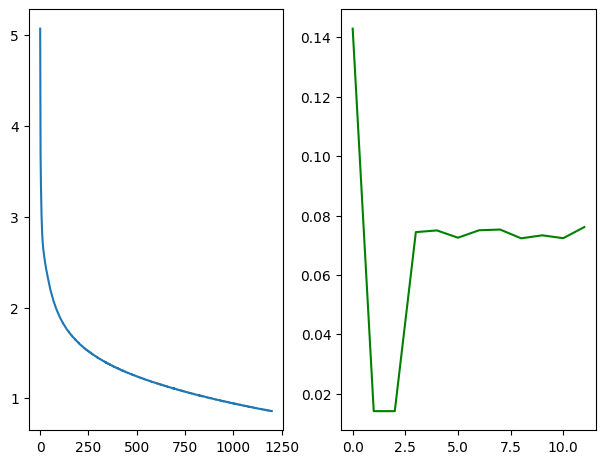

loss: 0.86, acc: 0.08


In [7]:

vit = VitXl(tokenizer.vocab_size, 256, 512, 4, 1024, 2, max_len=800, seq_len=512, mem_len=64)
# vit.load_state_dict(torch.load('/projets/melodi/gsantoss/models/pdfre.pt'))

model = PDFReader(vit, tokenizer.vocab_size, d_model=512, dim_feedforward=1024)

model = nn.DataParallel(model)
model.cuda(0)

crit = nn.NLLLoss(reduction='none')
optimizer = optim.Adam(model.parameters(), lr=0.00003)
batch_size = 32
epochs = 1200
lh = []
th = []
test = TensorDataset(*dataset[:10])
train = TensorDataset(*dataset[10:])
val = TensorDataset(*dataset[10:100])
progress = tqdm(total=epochs * math.ceil(len(train) / batch_size))

compiled = model

for e in range(epochs):
    el = []
    model.train()
    for x, y, ya in DataLoader(train, batch_size=batch_size, shuffle=True):
        optimizer.zero_grad()        
        res = compiled(x.cuda(0), y.long().cuda(0))
        rf = torch.flatten(res[:, :-1, :], start_dim=0, end_dim=1)
        yf = torch.flatten(y[:, 1:], start_dim=0, end_dim=1).cuda(0)
        loss = crit(rf, yf) * (yf != 0).float()
        loss = loss.sum() / (yf != 0).float().sum()
        loss.backward()
        el.append(loss.item())
        optimizer.step()
        progress.update(1)

    lh.append(sum(el) / len(el))
    if e % 100 == 0:
        th.append(model_eval(tokenizer, compiled, val, ml=512))

progress.close()
fig, ax = plt.subplots(1, 2)
fig.tight_layout()
ax[0].plot(lh)
ax[1].plot(th, c='g')
plt.show()

torch.save(model.module.state_dict(), '/projets/melodi/gsantoss/models/pdfr.pt' )
print(f'loss: {lh[-1]:0.2f}, acc: {th[-1]:0.2f}')

In [7]:
vit = VitXl(tokenizer.vocab_size, 256, 512, 4, 1024, 2, max_len=800, seq_len=512, mem_len=64)
# vit.load_state_dict(torch.load('/projets/melodi/gsantoss/models/pdfre.pt'))

model = PDFReader(vit, tokenizer.vocab_size, d_model=512, dim_feedforward=1024)
model.load_state_dict(torch.load('/projets/melodi/gsantoss/models/pdfr.pt'))
model.cuda(0)
# x, y, ya = train[0]
# 
# out = read(model, tokenizer, x.cuda(0), ml=1024, show_progress=True)
# tokenizer.decode(out)

/projets/melodi/gsantoss/miniconda3/envs/myenv/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


PDFReader(
  (encoder): VitXl(
    (v_encoder): Sequential(
      (0): Linear(in_features=256, out_features=1024, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=1024, out_features=512, bias=True)
      (4): Dropout(p=0.1, inplace=False)
    )
    (encoder_layer): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
      )
      (linear1): Linear(in_features=512, out_features=1024, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=1024, out_features=512, bias=True)
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x Tr

In [9]:
test = TensorDataset(*dataset[:10])
val = TensorDataset(*dataset[10:100])
model_eval(tokenizer, model, val, ml=512)

tensor(0.6811)

In [11]:
x, y, ya = val[0]

print(tokenizer.decode(y)[:512])
model.eval()
model.cuda(0)
out = model.read(tokenizer, x.cuda(0).unsqueeze(0), ml=512, show_progress=True)
print(out.shape)
print('-' * 50)
print(tokenizer.decode(out.squeeze(0).tolist()))


<s>![Figure 4: Comparing how models continue a prime (top left). Repeated motives and structure are seen in samples from Transformer with relative attention (top row), but less so from baseline Transformer (middle row) and PerformanceRNN (LSTM) (bottom row).](79,220)

### QUALITATIVE PRIMING EXPERIMENTS

When primed with an initial motif (Chopin's Étude Op. 10, No. 5) shown in the top left corner of Figure 4, we see the models perform qualitatively differently. Transformer with relative attention elaborates


  0%|          | 0/509 [00:00<?, ?it/s]

torch.Size([1, 512])
--------------------------------------------------
<s>![Figure 4: Comparing how models continue a prime (top left). Repeated motives and structure are seen in samples from Transformer with relative attention (top row), but less so from baseline Transformer (middle row) and PerformanceRNN (LSTM) (bottom row).](79,220)

### QUALITATIVE PRIMING EXPERIMENTS

When primed with an initial motif (Chopin's Étude Op. 10, No. 5) shown in the top left corner of Figure 4, we see the models perform qualitatively differently. Transformer with relative attention elaborate
